Project Goal:
The objective of this project is to develop a method for predicting future prices of Microsoft stock. This predictive insight is crucial for making informed investment decisions and strategic trading.
The project aims to:

* Forecast Stock Prices : Utilize historical data to predict future stock prices with LSTM. This will give us information on how the stock's price would change over time in the future.

* Risk Assessment through Monte Carlo Simulation: Apply the Geometric Brownian Motion (GBM) model within the Monte Carlo framework to assess risk and explore worst-case scenarios.

In [2]:
!pip install tensorflow

INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/276.5 MB ? eta -:--:--
   ---------------------------------------- 1.7/276.5 MB 36.1 MB/s eta 0:00:08
    --------------------------------------- 6.7/276.5 MB 71.7 MB/s eta 0:00:04
   - ------------------------------------- 11.7/276.5 MB 108.8 MB/s eta 0:00:03
   -- ------------------------------------- 16.4/276.5 MB 93.9 MB/s eta 0:00:03
   --- ------------------------------------ 21.3/276.5 MB 93.9 MB/s eta 0:00:03
   --- ------------------------------------ 25.9/276.5 MB 93.0 MB/s eta 0:00:03
   ---- ---------------------------------- 30.8/276.5 MB 108.8 MB/s eta 0:00:03
   ----- --------------------------------- 37.3/276.5 MB 108.8 MB/s eta 0:00:03
   ------ -------------------------------- 43.7/276.5 MB 108.8 MB/s eta 0:00:03
   ------ -------------------------------- 48.7/276.5 MB 108.8 M

  You can safely remove it manually.


In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [4]:
msft = yf.download('MSFT', start='2020-01-01', end='2023-12-30')
print(msft)

[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-01-02  158.779999  160.729996  158.330002  160.619995  153.938217   
2020-01-03  158.320007  159.949997  158.059998  158.619995  152.021393   
2020-01-06  157.080002  159.100006  156.509995  159.029999  152.414352   
2020-01-07  159.320007  159.669998  157.320007  157.580002  151.024658   
2020-01-08  158.929993  160.800003  157.949997  160.089996  153.430267   
...                ...         ...         ...         ...         ...   
2023-12-22  373.679993  375.179993  372.709991  374.579987  372.543915   
2023-12-26  375.000000  376.940002  373.500000  374.660004  372.623505   
2023-12-27  373.690002  375.059998  372.809998  374.070007  372.036713   
2023-12-28  375.369995  376.459991  374.160004  375.279999  373.240112   
2023-12-29  376.000000  377.160004  373.480011  376.040009  373.996002   

              Volume  
Date          

### I) Monte Carlo Simulation

A Monte Carlo simulation applies a selected model (that specifies the behavior of an instrument) to a large set of random trials in an attempt to produce a plausible set of possible future outcomes. In regard to simulating stock prices, the most common model is geometric Brownian motion (GBM).


1) What is the GBM model ?

A Geometric Brownian $(S_t)$ motion with parameters $\mu$ and $\sigma > 0 $ has the following expression :
$S_t = S_0 \exp \left( \sigma B_t + \mu t \right)$

Where $B_t$ is the standard Brownian motion.


2) Why would we use GBM ?

* A GBM process only assumes positive values, just like real stock prices.
* A GBM process shows the same kind of 'roughness' in its paths as we see in real stock prices : It has irregular, unpredictable fluctuations observed in the path of the stock price over time which aligns with stock prices which exhibit fluctuations with frequent ups and downs of variyng magnitudes.
* The logarithmic returns are normally distributed which is immediate using the formula above and calculating :

$$
\log \left( \frac{S_t}{S_{t-1}} \right) = \sigma \left( B_t - B_{t-1} \right) + \mu
$$

where $\epsilon_t = (B_t - B_{t-1}) $ follows a standard normal distribution.

Remark : $\epsilon_{t_1},..., \epsilon_{t_n}$ are independent because Brownian motion has independent increments.


In [4]:
msft['Log_Returns'] = np.log(msft['Close'] / msft['Close'].shift(1)).dropna()

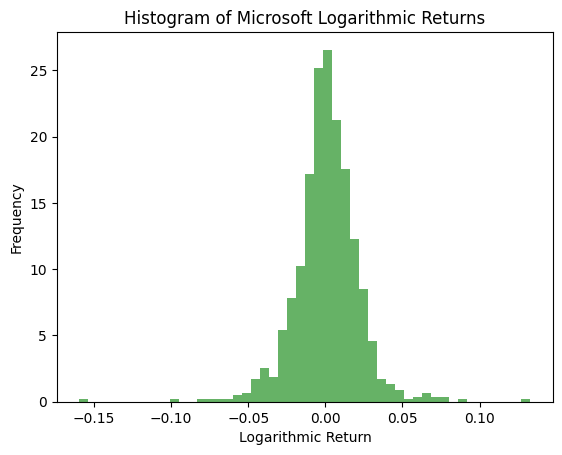

In [5]:
plt.hist(msft['Log_Returns'].dropna(), bins=50, density=True, alpha=0.6, color='g')
plt.title('Histogram of Microsoft Logarithmic Returns')
plt.xlabel('Logarithmic Return')
plt.ylabel('Frequency')
plt.show()

The histogram shows that the Logarithmic Returns of the stock do follow a Standard Normal distribution which encourages us to use GBM model.

3) How are we going to use Geometric Brownian Motion ?

The Geometric Brownian motion we will use will be the following :

$S_t = S_0 e^{\mu t} e^{\sigma B_t - \frac{\sigma^2 t}{2}}$

where:

- $S_t$ is the stock price at time $t$,
- $S_0$ is the initial stock price,
- $\mu$ is the drift term (mean return),
- $\sigma$ is the volatility of the stock price,
- $B_t$ is the standard Brownian motion (Wiener process).

It is often used in Finance, especially for the future evolution of stock prices. However, this formula is for continuous time. In our case, we have discrete time steps (1 day). So in order to have a discrete-Time approximation we need to break time into small intervals of size $dt$. Naturally, since we consider one year in the future, $dt = 1 / 365 $ which aligns with daily increments. In other terms, $t_{i+1} - t_i = dt
\text{, for all } i \in \{0, 1, 2, \ldots, 364\}$.
Consequently, $\frac{S_{t_{i+1}}}{S_{t_i}} = \exp\left[\left(\mu - \frac{\sigma^2}{2}\right) dt + \sigma \sqrt{dt} \epsilon_i\right]$

With $\epsilon_i $ is a random variable drawn from a standard normal distribution (representing the stochastic component).

$\epsilon_i$ are i.i.d because Brownian motion has independent increments.



In [6]:
msft_close = msft['Close']
returns_msft = msft_close.pct_change().dropna()
print(returns_msft)

Date
2020-01-03   -0.012452
2020-01-06    0.002585
2020-01-07   -0.009118
2020-01-08    0.015928
2020-01-09    0.012493
                ...   
2023-12-22    0.002784
2023-12-26    0.000214
2023-12-27   -0.001575
2023-12-28    0.003235
2023-12-29    0.002025
Name: Close, Length: 1005, dtype: float64


In [7]:
dt = 1/365
mu = returns_msft.mean()
sigma = returns_msft.std()
start_price = 376.040009  # At 2023-12-29

In [8]:
def stock_monte_carlo(start_price, days, mu, sigma):
    price = np.zeros(days)
    price[0] = start_price
    for t in range(1, days):
        eps_t= np.random.normal(loc=0, scale=1)
        price[t] = price[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * eps_t)

    return price

## Let's visualize how the evolution of stock prices would look like

Text(0.5, 1.0, 'Monte Carlo Analysis for Microsoft')

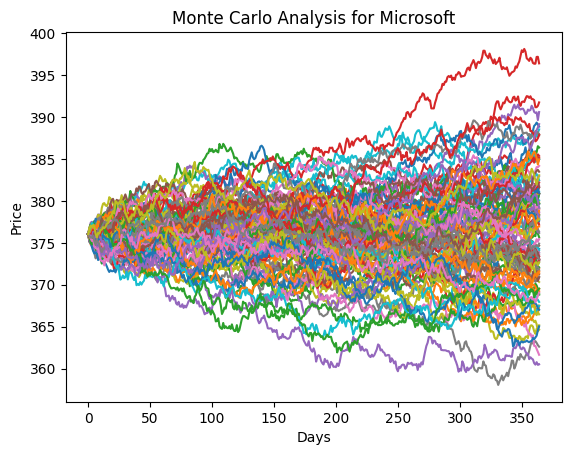

In [9]:
for run in range(1,100):
    plt.plot(stock_monte_carlo(start_price,365,mu,sigma))
plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Monte Carlo Analysis for Microsoft')

# Let's run 10000 simulations

In [10]:
runs = 10000
days = 365
simulations = np.zeros(runs)

for run in range(1,runs):
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1]

We can do many studies on these simulations : For example we can calculate the average final price (in 365 days) and see the worst case scenario with a 99% confidence interval. This actually corresponds the Value at Risk.

Text(0.5, 1.0, 'Final price distribution for Microsoft Stock after 365 days')

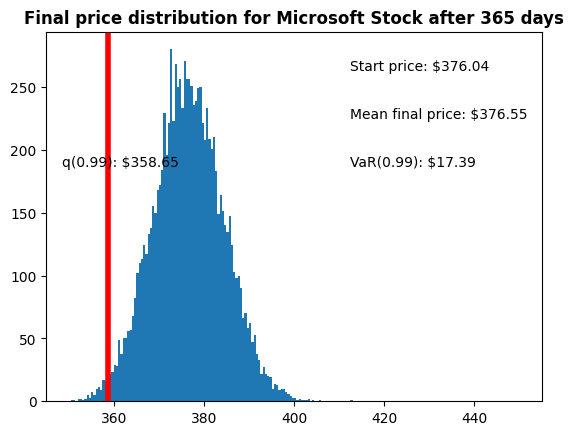

In [11]:
q = np.percentile(simulations,1)

plt.hist(simulations,bins=200,range = [350,450])

plt.figtext(0.6,0.8,s="Start price: $%.2f" %start_price)

plt.figtext(0.6,0.7,"Mean final price: $%.2f" % simulations.mean())

plt.figtext(0.6,0.6,"VaR(0.99): $%.2f" % (start_price -q,))

plt.figtext(0.15,0.6, "q(0.99): $%.2f" % q)

plt.axvline(x=q, linewidth=4, color='r')

plt.title(u"Final price distribution for Microsoft Stock after %s days" %days, weight='bold')

In this case, the mean final price was 376.55 Dollars and VaR with 99% was 17.39 Dollars. which means that with 99% probability, the price won't go below 358.65 Dollars

2) Using LSTM to forecast daily prices of Microsoft for one year


A Long Short-Term Memory (LSTM) network is a type of recurrent neural network (RNN) designed to handle sequential data and remember important information over long time periods. Unlike traditional RNNs, which struggle with learning long-term dependencies due to the vanishing gradient problem, LSTMs use special structures called gates to control the flow of information. These gates help the network decide which information to keep, which to forget, and which to pass on to the next step. This makes LSTMs particularly well-suited for tasks that involve time series data, like stock price forecasting, where understanding past values is crucial for predicting future trends.

We will need more data in order for the lstm model to be as accurate as possible. For that we will take up to 9 years of data.

We will do the forecast on a short period of time (about 3 months).

We will use a sequence length of 5 days.

In [ ]:
msft = yf.download('MSFT', start='2010-01-01', end='2019-01-05')
msft.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
msft = msft.drop(['Date', 'Adj Close'], axis = 1)

In [ ]:
msft = msft.dropna()
msft.head()

,Open,High,Low,Close,Volume
0,30.620001,31.100000,30.590000,30.950001,38409100
1,30.850000,31.100000,30.639999,30.959999,49749600
2,30.879999,31.080000,30.520000,30.770000,58182400
3,30.629999,30.700001,30.190001,30.450001,50559700
4,30.280001,30.879999,30.240000,30.660000,51197400


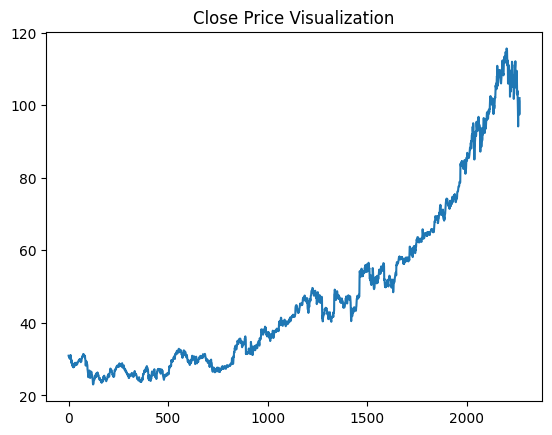

In [ ]:
plt.title("Close Price Visualization")
plt.plot(msft.Close)

In [ ]:
data = msft.Close

## Split data into train and test data

In [ ]:
train_close = pd.DataFrame(data[0:int(len(data)*0.8)])
rest_close = pd.DataFrame(data[int(len(data)*0.8): int(len(data))])

In [ ]:
validate_close = pd.DataFrame(rest_close[0:int(len(rest_close)*0.8)])
test_close = pd.DataFrame(rest_close[int(len(rest_close)*0.8): int(len(rest_close))])

In [ ]:
print(test_close.shape, validate_close.shape,train_close.shape)

(91, 1) (363, 1) (1813, 1)


## Use scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [ ]:
data_training_array = scaler.fit_transform(train_close)

In [ ]:
data_validation_array = scaler.transform(validate_close)

In [ ]:
data_test_array = scaler.transform(test_close)

In [ ]:
# Sequence length
sequence_length = 5
x_train, y_train = [], []
x_validation, y_validation = [], []
x_test, y_test = [], []

for i in range(sequence_length, data_training_array.shape[0]):
    x_train.append(data_training_array[i-sequence_length:i])
    y_train.append(data_training_array[i, 0])

combined_validation_data = np.concatenate((data_training_array[-sequence_length:], data_validation_array), axis=0)

# Prepare validation sequences
for i in range(sequence_length, combined_validation_data.shape[0]):
    x_validation.append(combined_validation_data[i-sequence_length:i])
    y_validation.append(combined_validation_data[i, 0])


combined_test_data = np.concatenate((data_validation_array[-sequence_length:], data_test_array), axis=0)

# Prepare test sequences
for i in range(sequence_length, combined_test_data.shape[0]):
    x_test.append(combined_test_data[i-sequence_length:i])
    y_test.append(combined_test_data[i, 0])

# Convert lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_validation, y_validation = np.array(x_validation), np.array(y_validation)
x_test, y_test = np.array(x_test), np.array(y_test)

# Print shapes to verify
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_validation shape:", x_validation.shape)
print("y_validation shape:", y_validation.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (1808, 5, 1)
y_train shape: (1808,)
x_validation shape: (363, 5, 1)
y_validation shape: (363,)
x_test shape: (91, 5, 1)
y_test shape: (91,)


In [ ]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences=True
              ,input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))


model.add(LSTM(units = 60, activation = 'relu', return_sequences=True))
model.add(Dropout(0.3))


model.add(LSTM(units = 80, activation = 'relu', return_sequences=True))
model.add(Dropout(0.4))


model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 5, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 5, 60)               │          26,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 5, 80)               │          45,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 80)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 120)                 │          96,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, validation_data = (x_validation, y_validation) ,epochs = 10)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - loss: 0.1167 - val_loss: 11.6534
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0122 - val_loss: 1.4823
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0083 - val_loss: 0.1010
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0060 - val_loss: 0.0348
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0056 - val_loss: 0.0114
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0062 - val_loss: 0.0073
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0050 - val_loss: 0.0068
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0050 - val_loss: 0.0059
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0049 - val_loss: 0.0085
Epoch 10/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0049 - val_loss: 0.0192


In [ ]:
# Make predictions on the test set
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_original= scaler.inverse_transform(y_test.reshape(-1, 1))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


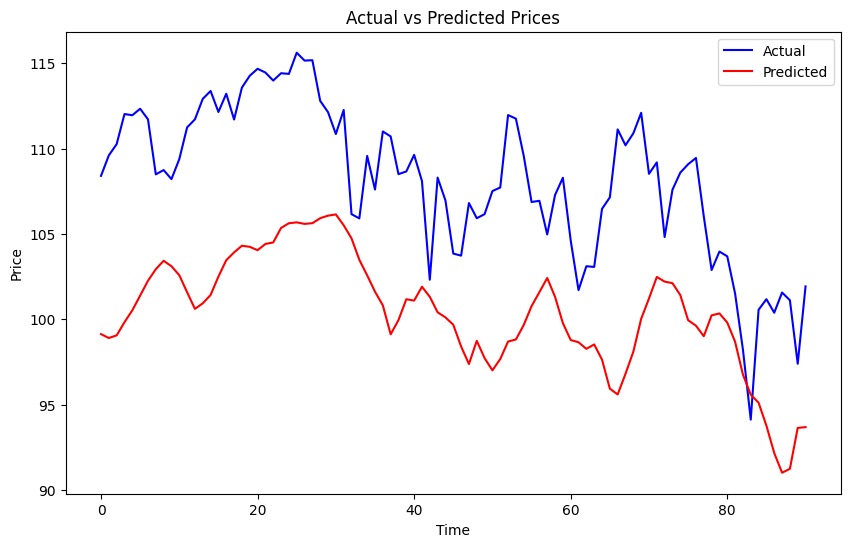

In [ ]:
# Plot the actual values against the predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, color='blue', label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


The result is not perfect but it's not far from reality. The model has identified the trend and the fluctuations, the values aren't exact but the evolution of prices is really close to what we see in the reality. Based on this we can have an insight on the evolution of prices over time.

To make the model more precise : We can do hyperparameters tuning using Optuna.
We can also do Features Engineering which might enhance the precision of the model

Conclusion : These two tools can help us understand the dynamics of a market or at least give us insights on the worst case scenarios based on statistical strategies.  